# **Sentiment Analysis using RNN-**

## **Data loading and Preprocessing-**

In [ ]:
import torch
import torchtext
from torchtext.data import get_tokenizer
import torchtext.datasets as datasets
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torchtext.datasets import IMDB
from IPython.display import HTML, IFrame
import torch.nn as nn
import time
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
!pip install torchtext==0.9

In [ ]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True  #https://pytorch.org/docs/stable/notes/randomness.html

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [ ]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

In [ ]:
print(vars(train_data.examples[64]))

In [ ]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Next is the use of pre-trained word embeddings. Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors. We get these vectors simply by specifying which vectors we want and passing it as an argument to build_vocab. TorchText handles downloading the vectors and associating them with the correct words in our vocabulary.

Here, we'll be using the "glove.6B.100d" vectors". glove is the algorithm used to calculate the vectors, go here for more. 6B indicates these vectors were trained on 6 billion tokens and 100d indicates these vectors are 100-dimensional.

In [ ]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

In [ ]:
print(f"Unique tokens in LABEL vocabulary: {(LABEL.vocab.freqs)}")

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

In [ ]:
print(TEXT.vocab.itos[:10])

The final step of preparing the data is creating the iterators. We iterate over these in the training/evaluation loop, and they return a batch of examples (indexed and converted into tensors) at each iteration.

We'll use a BucketIterator which is a special type of iterator that will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.

We also want to place the tensors returned by the iterator on the GPU (if you're using one). PyTorch handles this using torch.device, we then pass this device to the iterator.

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE,sort_within_batch = True,device = device)

In [ ]:
def TabularFormat(epochs,train_cost,train_acc,eval_cost,eval_acc):
  ep = []
  for i in range(1,epochs+1):
    ep.append(i)
  return pd.DataFrame(list(zip(ep,train_cost,train_acc,eval_cost,eval_acc)),columns = ['Epoch Value','Training Loss','Training Accuracy','Validation loss','Validation Accuracy'])

In [ ]:
def GraphicalFormat(epochs,train_cost,train_acc,eval_cost,eval_acc):
  ep = []
  for i in range(1,epochs+1):
    ep.append(i)

  plt.figure(figsize =(12,7))
  plt.plot(ep,eval_cost,label = "Evaluation Loss")
  plt.plot(ep,train_cost,label = "Training Loss")
  plt.ylabel("Loss",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12,loc = "best")
  plt.title("Graph between value of Trainig and Validation Loss V/s Epochs",fontsize = 15)
  plt.show()
  print("\n\n__________________________________________________\n\n")
  plt.figure(figsize =(12,7))
  plt.plot(ep,train_acc,label = "Training Accuracy")
  plt.plot(ep,eval_acc,label = "Evaluation Accuracy")
  plt.ylabel("Accuracy",fontsize = 15)
  plt.xlabel("No. of Epoch",fontsize = 15)
  plt.legend(fontsize = 12,loc = "best")
  plt.title("Graph between Trainig and Validation Accuracies V/s Epochs",fontsize = 15)
  plt.show()

## **Defining the Base model-**

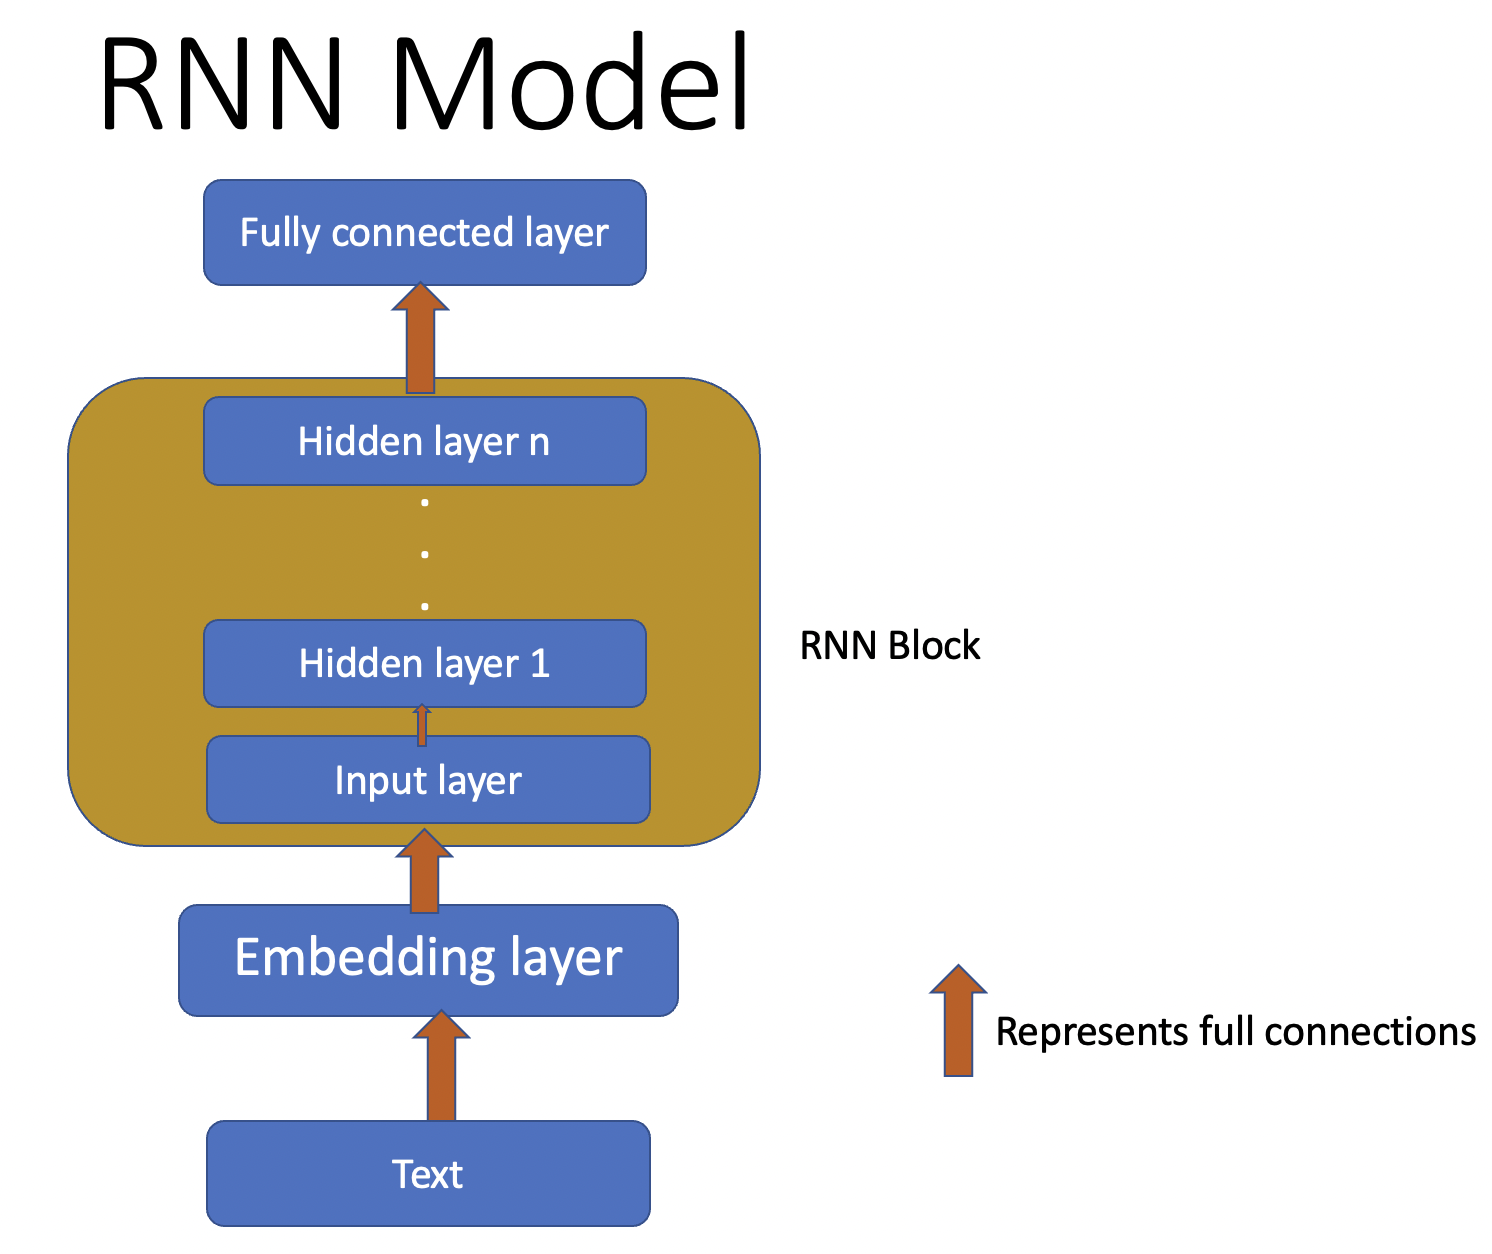

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.0
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.5, weight_decay=0.0001)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc



def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        #print the text and text_lengths just for one example
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
import pandas as pd
pd = TabularFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

In [ ]:
GraphicalFormat(N_EPOCHS,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

# **Observation-**

As we can see, the model is still learning as loss in decreasing and the model has not converged yet. We can increase the epochs and see at what number of iterations we get a decent accuracy on validation dataset.

# **Scribing Exercise 1:**

For each of the experiment listed below, submit the graphs between training accuracy, validation accuracy vs epochs and training loss, validation loss vs epochs for each hyper-parameter as **scribes**-

# **1.** 
Run the above RNN model with the given set of learning rate values for atleast 100 epochs for each learning rate and submit the graphs as instructed above-

Also, write the best learning rate value for this model from the given set of values.

Learning rate values-

    1. 0.00001
    2. 0.0001
    3. 0.001
    4. 0.01
    5. 0.1 

Comment on your observations.

# **2.** 
With the best learning rate value you got, utilize **learning rate scheduler** from the given LR schedulers for 100 epochs and give graphs for each as instructed-

LR Schedulers-

    1. MultiStep LR
    2. Cyclic LR
    3. Exponential LR

Comment on your observations. 

# **3.**

With the best hyper-parameter values you got upto this point, increase the number of layers in RNN to $[2,3,4]$. For each of the given values, set Bi-directional as FALSE for one time and TRUE for another (two subproblems for each value). Also implement **early stopping** condition with patience value of **3** for each and submit the graphs as scribes.

Comment on your observations. 



# **LSTM-**

## **LSTM with constant LR-**

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)

        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))

        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.7, weight_decay=0.0001)

model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc



def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()   
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')
prev_epoch_valid_loss = float('inf')
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
patience = 3
i = 0
max_epochs = 50

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, valid_loss))
        torch.save(model.state_dict(), 'tut1-model.pt')

    if valid_loss_list[-1]<prev_epoch_valid_loss:
      i = 0
      prev_epoch_valid_loss = valid_loss_list[-1]

    else:
      i = i + 1
      prev_epoch_valid_loss = valid_loss_list[-1]

    if i>=patience:
      print("Early Stopping")
      print("Returning the model with best parameters")
      break
    if epoch >= max_epochs:
      print("Max Epochs reached")
      print("Returning the model with best parameters")
      break

In [ ]:
import pandas as pd
pd = TabularFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

In [ ]:
GraphicalFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

# **Exercise 2:**

For each of the experiment listed below, submit the graphs between training accuracy, validation accuracy vs epochs and training loss, validation loss vs epochs for each hyper-parameter as **scribes**-

# **1.** 
Run the above LSTM model with ADAM optimizer with default parameter settings,  for atleast 100 epochs and submit the graphs as instructed above. Write your observations. 

# **2.**

With ADAM optimizer, increase the number of layers in LSTM to $[2,3,4]$. For each of the given values, set Bi-directional as FALSE for one time and TRUE for another (two subproblems for each value). Also implement **early stopping** condition with patience value of **3** for each and submit the graphs as scribes. Comment on observations. 



# **GRU-**

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)

        
        self.fc = nn.Linear(hidden_dim * n_layers, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, hidden = self.rnn(packed_embedded)

        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden.squeeze(0))


#Initialising the model
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 1
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM,  HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)
print("The overall model is - \n")
print(model)
dash = "________________________________________________________________________\n\n"
print(dash)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())


model = model.to(device)
criterion = criterion.to(device)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# if (torch.cuda.is_available()):
#     model.cuda()


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
N_EPOCHS = 20

best_valid_loss = float('inf')
prev_epoch_valid_loss = float('inf')
prev_epoch_train_acc = 0
prev_epoch_valid_acc = 0
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []
patience = 3
i = 0
difference = 5
j = 0
max_epochs = 50

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc*100)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc*100)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, valid_loss))
        torch.save(model.state_dict(), 'tut1-model.pt')

    if valid_loss_list[-1]<prev_epoch_valid_loss:
      i = 0
      prev_epoch_valid_loss = valid_loss_list[-1]

    else:
      i = i + 1
      prev_epoch_valid_loss = valid_loss_list[-1]

    if i>=patience:
      print("Early Stopping")
      print("Returning the model with best parameters")
      break
    if epoch >= max_epochs:
      print("Max Epochs reached")
      print("Returning the model with best parameters")
      break

    if train_acc_list[-1] - valid_acc_list[-1] < difference:
      j = 0

    else:
      print("Model has started to Over train.")
      j = j+1

    if j>3:
      print("Model overtrained for continious 3 epochs. STOPPING THE TRAINING and returning the best parameters.")
      break

In [ ]:
import pandas as pd
pd = TabularFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)
pd

In [ ]:
GraphicalFormat(epoch+1,train_loss_list,train_acc_list,valid_loss_list,valid_acc_list)

# **Exercise 3:**


# **1.** 
Try to come up with hyper-parameters so that over-fitting can be reduced in the above GRU model along with good validation accuracy values. For example, you can change number of layers, Bi-directional, learning rate, embedding dimensions, early stopping, etc. and submit the graphs for each experiment you try as scribes. Comment about the settings which give you better validation accuracy with reduced overfitting. 
 

# **Testing-**

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    if prediction.item()>0.5:
      return 'Positive'
    else:
      return 'Negative'
    # return prediction.item()

In [ ]:
predict_sentiment(model, "This movie is really good")

In [ ]:
predict_sentiment(model, "You should watch this movie only if you nothing else to do.")

In [ ]:
predict_sentiment(model, "I've had mosquito bites that were more passionate than this undead, unrequited, and altogether unfun pseudo-romantic riff on Romeo and Juliet")

In [ ]:
predict_sentiment(model, "An outstanding and brilliantly made movie after a long time. Usually, I do not encourage bollywood movies but this movie has a storyline that needs your patience and a full on theatrical retreat. ")

In [ ]:
predict_sentiment(model, "Movie is an average entertainer.. first half is boring..  jumping from one scene from another .. Content and timing of dialogues are utter nonsense,  seems to be written by inexperienced person .. Ranbir kapoor is good , tried his best with poor dialogues ... alia - Ranbir love story is over emphasized , forceful introduction of alia in few scenes when it was not required .. and body movements of Ranbir during visions was totally hilarious ..Second half was better ... but use of words like button , bhasad seems imbecile with movie titles like brahmastra .. and doing ending like bahubali lacks originality .. Vfx were good ..Bolloywood needs some originality , brains and better script writing and mature content .. Brahmastra is just one time watch .. only if you have time and longing for a time pass movie..")

In [ ]:
predict_sentiment(model, "I never thought that this movie would be good, but it turned out to be great")

In [ ]:
predict_sentiment(model, "While I had the misfortune to see 'Bright' in a theater, most people will simply press 'play' out of curiosity on their TV remote. I am willing to concede that this might elevate the experience a little ... the ability to take a quick trip to the kitchen or restroom after shouting 'no, don't pause it' to your partner on the couch will be liberating.")

**Testing on whole test dataset-**

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')